In [1]:
import pandas as pd
import numpy as np

from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import signal

import warnings
from itertools import combinations
from datetime import date
import time
from sklearn.model_selection import train_test_split

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

import pmdarima as pm

warnings.filterwarnings( "ignore")
sns.set_theme(style='whitegrid', palette='pastel')

plt.rcParams["figure.figsize"] = (12, 8)

# Step 1: Data preprocessing into time series

In [2]:
path = 'https://drive.google.com/file/d/1i_VkX57he5_QICWnX-egL2AHpW0yEDvd/view?usp=share_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]

df = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
df.drop(df.columns[0], axis=1, inplace=True)

print(list(df.columns))
df.head()

['id', 'long', 'lat', 'light', 'weather', 'nearby', 'road_conditions', 'category', 'severity', 'datetime', 'region', 'parent_region', 'participants_count', 'injured_count', 'dead_count', 'month', 'weekday', 'time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph']


,id,long,lat,light,weather,nearby,road_conditions,category,severity,datetime,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1561495,37.608056,55.689444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Крупный торгов...","['Заснеженное', 'Отсутствие, плохая различимос...",Наезд на препятствие,С погибшими,2015-01-01 00:23:00,...,-10,12,100,96,0.0,1011,-6,2,263,9
1,2365887,91.543006,55.361608,"В темное время суток, освещение не включено",['Ясно'],[],['Сухое'],Наезд на препятствие,Тяжёлый,2015-01-01 00:50:00,...,-16,15,68,96,0.0,1025,-12,2,212,7
2,1561392,37.752778,55.661667,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Нерегулируемый...",['Обработанное противогололедными материалами'],Наезд на пешехода,Тяжёлый,2015-01-01 01:00:00,...,-10,16,100,96,0.0,1010,-6,3,268,11
3,1913663,1.000000,1.000000,"В темное время суток, освещение включено",['Пасмурно'],[],['Мокрое'],Наезд на стоящее ТС,Легкий,2015-01-01 01:15:00,...,-3,22,91,97,0.0,1008,1,5,271,13
4,1561530,37.405833,55.649444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Выезд с прилег...","['Недостатки зимнего содержания', 'Заснеженное']",Столкновение,Тяжёлый,2015-01-01 01:39:00,...,-10,16,100,96,0.0,1010,-6,3,268,11


4 chosen variables are:
- tempC (predictor);
- visibility (predictor);
- injured_count (target variable);
- severity (target variable).

Preprocessing of variables:
- tempC - average over the day;
- visibility - average over the day;
- injured_count - average over the day;
- severity - mapping severity levels to integers starting from 1 (there may be days with no accidents), then average over day.

In [3]:
ts = df[['datetime', 'tempC', 'visibility', 'injured_count', 'severity']].copy()
print(f"Unique severity levels: {list(df['severity'].unique())}")

sev_map = {'С погибшими': 3, 'Тяжёлый': 2, 'Легкий': 1}
map_severity = lambda x: sev_map[x]

ts['datetime'] = pd.to_datetime(ts['datetime']).dt.date
ts['severity'] = ts['severity'].apply(map_severity)

print(f"Dates from {df['datetime'].min()} to {df['datetime'].max()}")
ts = ts.groupby(['datetime']).mean()
ts.head()

Unique severity levels: ['С погибшими', 'Тяжёлый', 'Легкий']
Dates from 2015-01-01 00:23:00 to 2022-10-31 21:03:00


,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,-2.574468,5.829787,1.255319,1.553191
2015-01-02,-2.040000,5.460000,1.640000,1.540000
2015-01-03,-5.790698,3.906977,1.209302,1.697674
2015-01-04,-5.666667,5.300000,1.033333,1.433333
2015-01-05,-10.687500,5.531250,1.187500,1.468750


Number of days: 2861


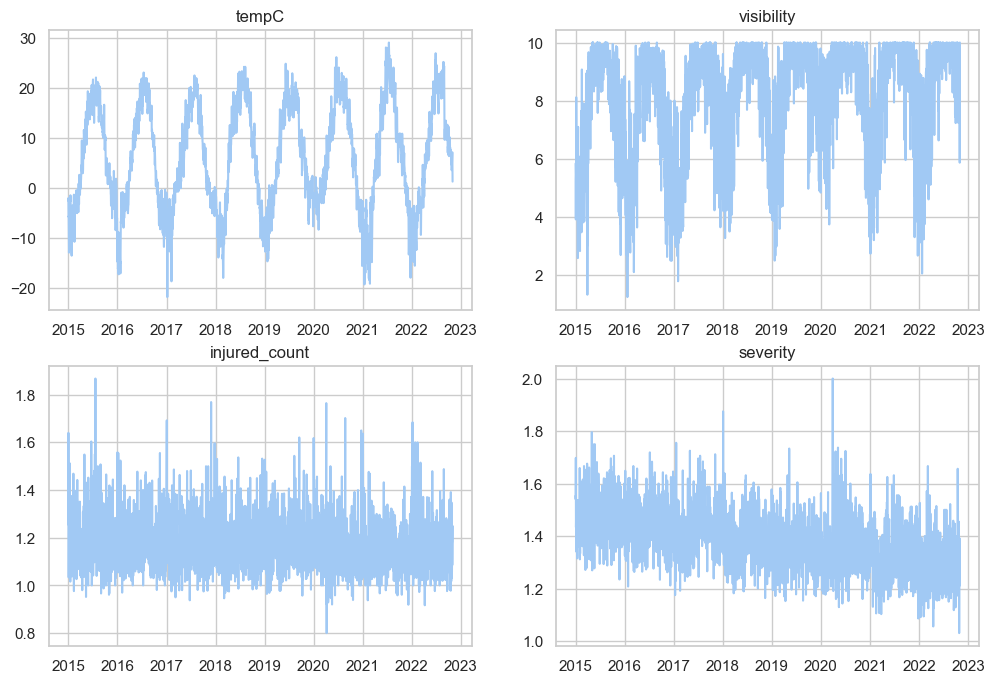

In [4]:
print(f"Number of days: {len(ts)}")

for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(ts[item])

# Step 2: Stationarity analysis

In [5]:
for num, item in enumerate(ts.columns):
    result = smt.stattools.adfuller(ts[item])
    print(f"\nVariable: {item}")
    print("Augmented Dickey-Fuller test:")
    print(f"\tStatistic value = {result[0]:.5f}\n\tp-value = {result[1]:.5f}")
    print("\tStationary" if (result[1] < 0.05) and \
          (result[0] < result[4]['5%']) else "\tNon-stationary")


Variable: tempC
Augmented Dickey-Fuller test:
	Statistic value = -3.40413
	p-value = 0.01082
	Stationary

Variable: visibility
Augmented Dickey-Fuller test:
	Statistic value = -4.49780
	p-value = 0.00020
	Stationary

Variable: injured_count
Augmented Dickey-Fuller test:
	Statistic value = -7.77946
	p-value = 0.00000
	Stationary

Variable: severity
Augmented Dickey-Fuller test:
	Statistic value = -3.05193
	p-value = 0.03032
	Stationary


All four time series seemed to be stationary for mathematical expectation and variance (with the augmented Dickey-Fuller test). No further processing is needed.

# Step 3: Analysis of covariance among targets and predictors 

## Autocovariance

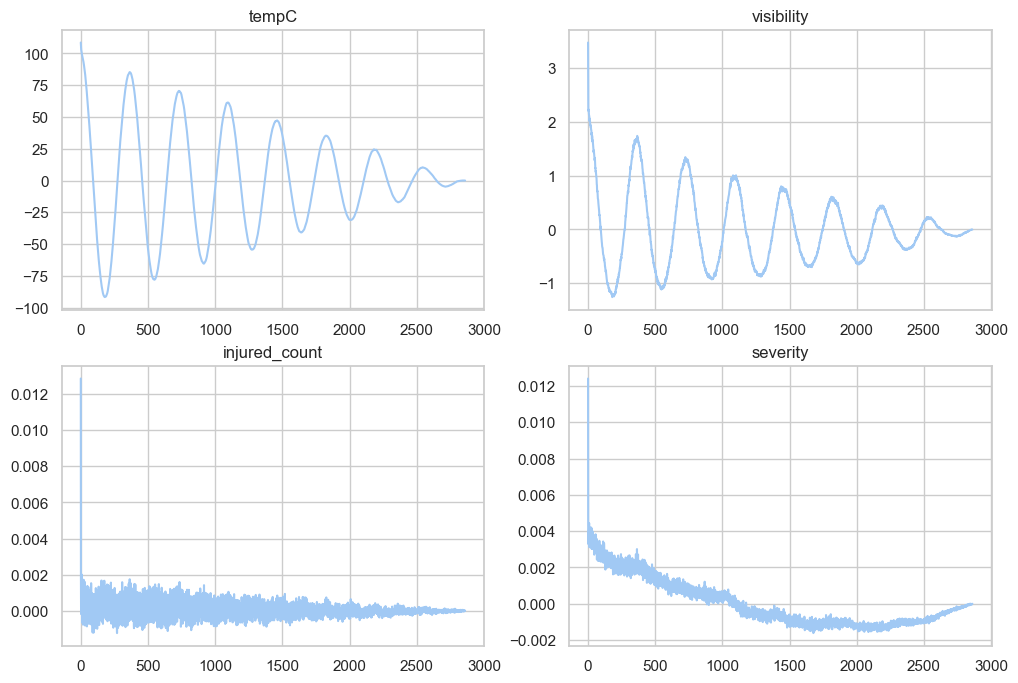

In [6]:
for num, item in enumerate(ts.columns):
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(stattools.acovf(ts[item], fft=False)) # autocovariance without window

Autocovariance:
1. tempC and visibility show significant yearly autocovariance;
2. injured_count and severity may have very slight autocovariance with smaller periods.

As point 1 is obvious, point 2 is not, so are better visualized with ACF plots:

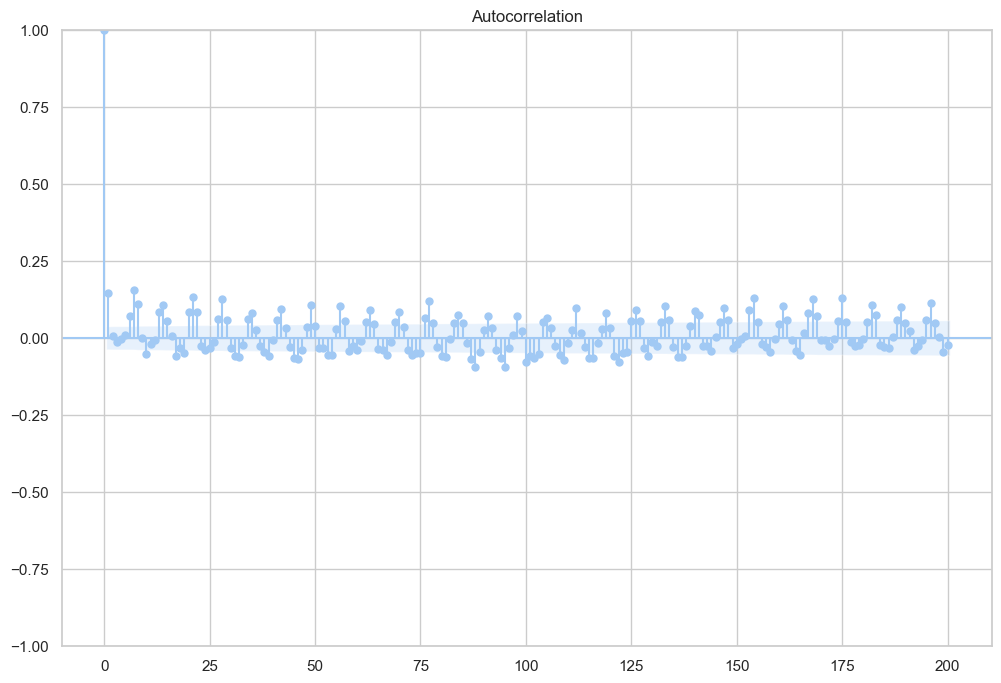

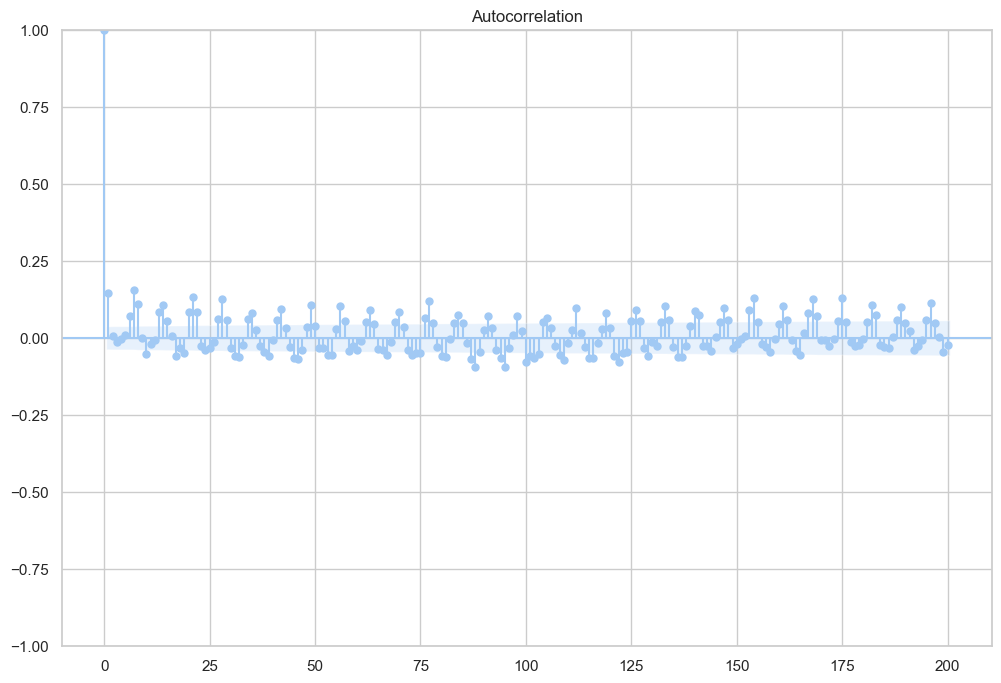

In [7]:
plot_acf(ts['injured_count'], lags=200)

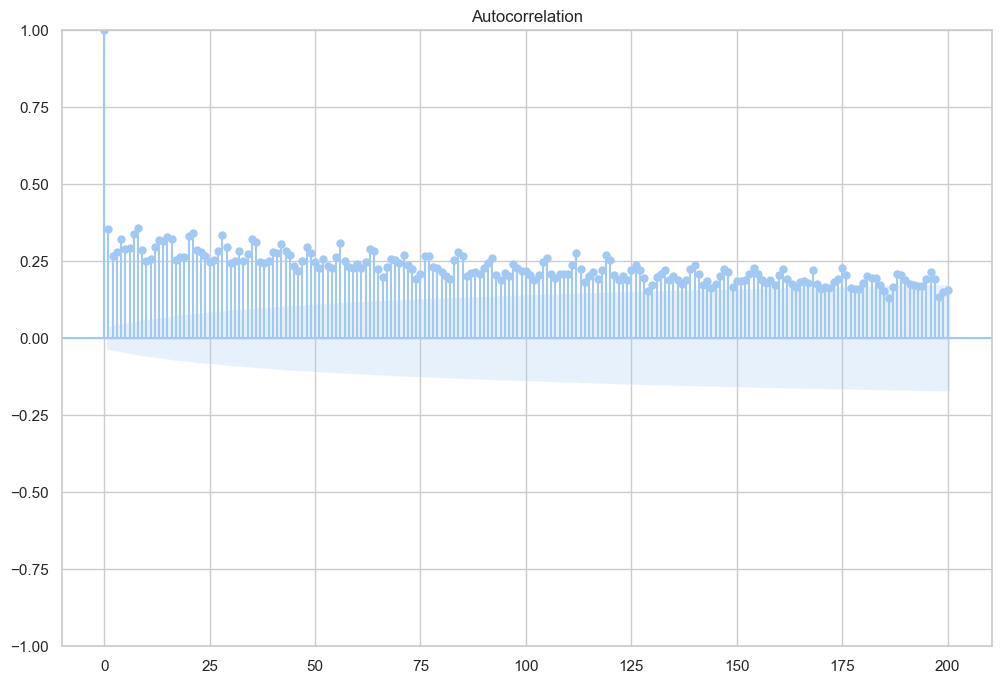

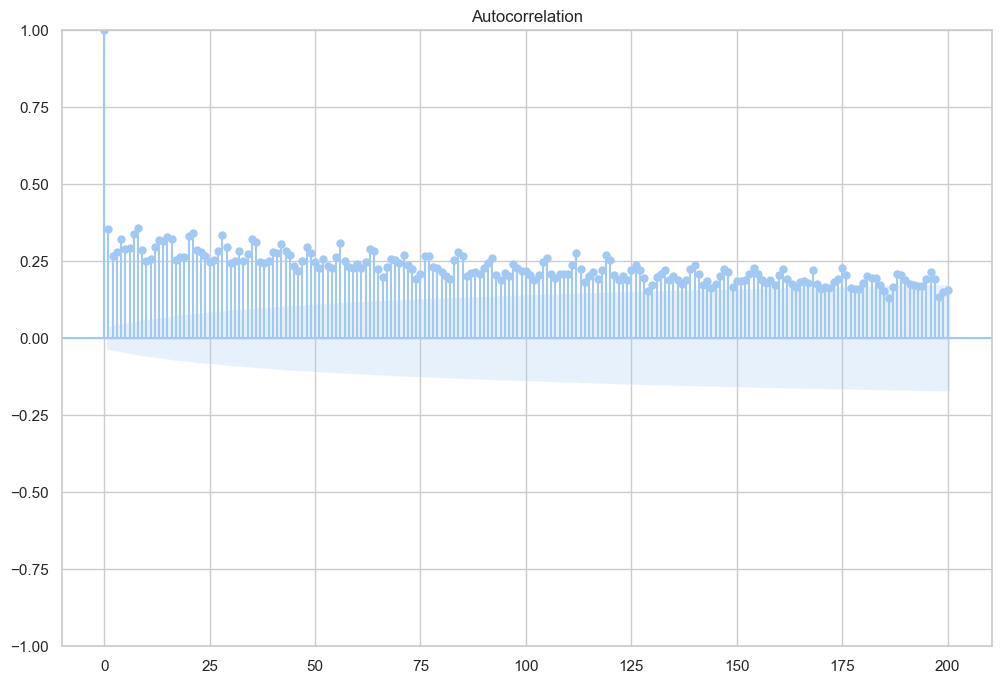

In [8]:
plot_acf(ts['severity'], lags=200)

As we can see, there are slight weekly autocorrelations.

## Mutual correlation

Get all unique pairs of variables and define cross correlation function.

In [9]:
pairs = [comb for comb in combinations(list(ts.columns), 2)]
for i in pairs:
    print(i)
    
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    
    Returns
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

('tempC', 'visibility')
('tempC', 'injured_count')
('tempC', 'severity')
('visibility', 'injured_count')
('visibility', 'severity')
('injured_count', 'severity')


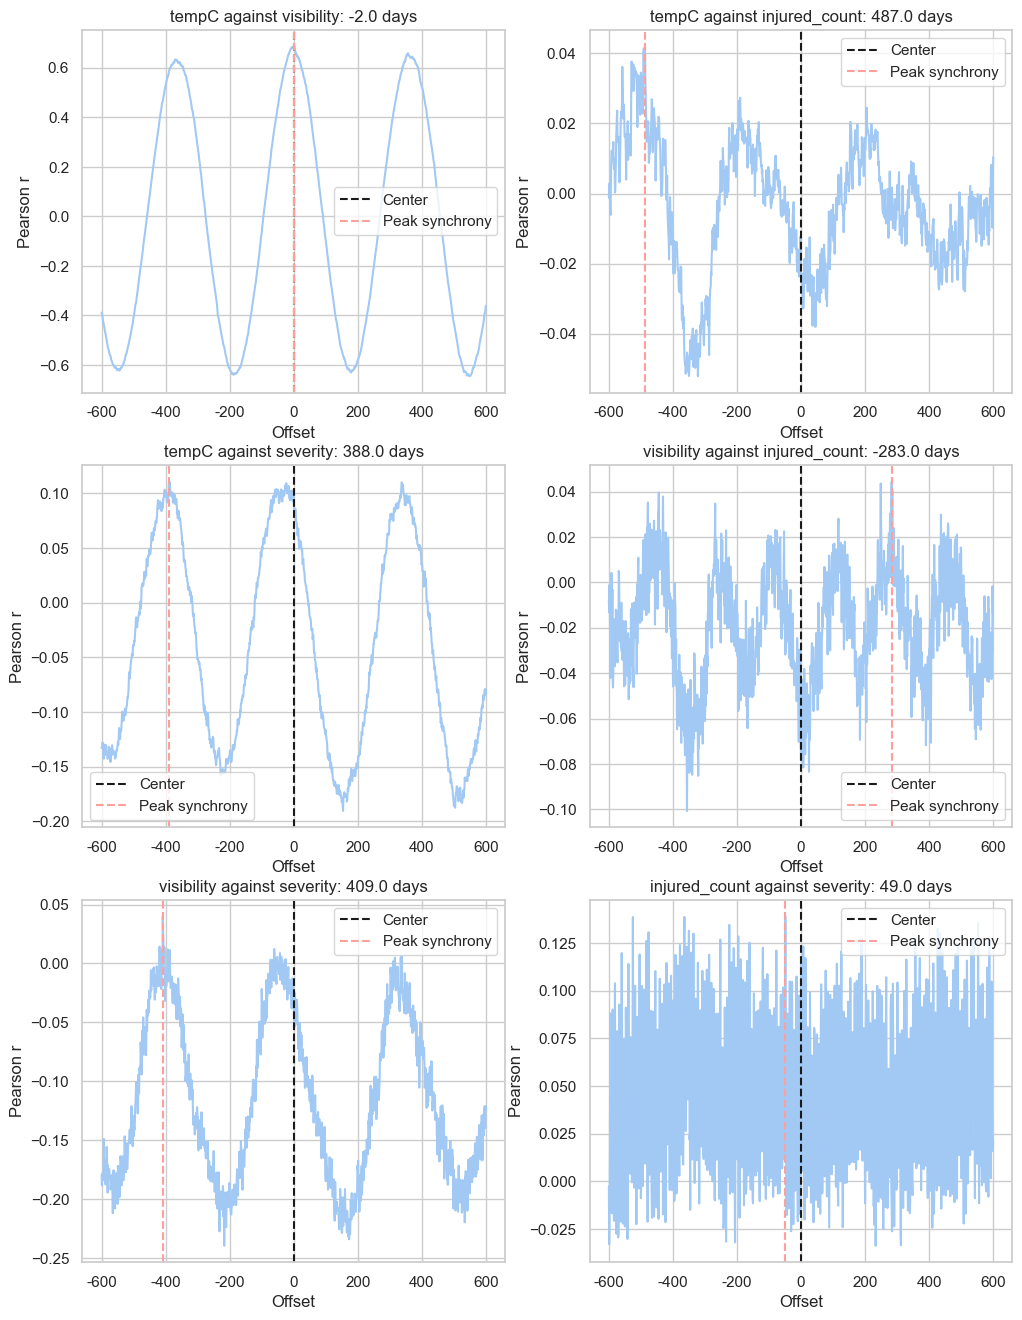

In [10]:
plt.rcParams["figure.figsize"] = (12, 16)
max_lag = 600

for num, pair in enumerate(pairs):
    plt.subplot(3, 2, num+1)
    t1 = ts[pair[0]]
    t2 = ts[pair[1]]
    
    rs = [crosscorr(t1, t2, lag) for lag in range(-int(max_lag),int(max_lag+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)

    plt.plot(rs)
    plt.axvline(np.ceil(len(rs)/2), color='k', linestyle='--', label='Center')
    plt.axvline(np.argmax(rs), color='r', linestyle='--', label='Peak synchrony')
    plt.title(f"{pair[0]} against {pair[1]}: {offset} days")
    plt.xlabel('Offset')
    plt.ylabel('Pearson r')
    plt.xticks(list(range(0, 1401, 200)), labels=[i-max_lag for i in list(range(0, 1401, 200))])
    plt.xlim(right=(max_lag*2+60))
    plt.legend()

plt.rcParams["figure.figsize"] = (12, 8)

As we can see, there are strong cross-correlations between all of the variables in the triple (tempC, visibility, severity).

Some cross-correlation is observed between pairs (injured_count, tempC) and (injured_count, visibility).

No visible cross-correlation between injured_count and severity (target variables).

Such cross-correlations make the case where all predictors are at least somehow correlated with the targets. Here, severity will probably be the target to yield better quality models.

# Step 4: high-frequency noise filtering

Rolling window smoothing and gaussian filter are used.

In [11]:
window_size = 15
std = 1
ts_roll = ts.rolling(window=window_size, center=True).mean()
ts_gauss = ts.rolling(window=window_size, win_type='gaussian', center=True).mean(std=std)
ts_roll.head(10)

,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN
2015-01-08,-6.248853,5.563798,1.270874,1.461260
2015-01-09,-6.258174,5.574087,1.254911,1.457185


In [12]:
ts_gauss.head(10)

,tempC,visibility,injured_count,severity
datetime,,,,
2015-01-01,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN
2015-01-08,-10.321704,5.846423,1.325923,1.454778
2015-01-09,-7.658636,5.277511,1.336004,1.433496


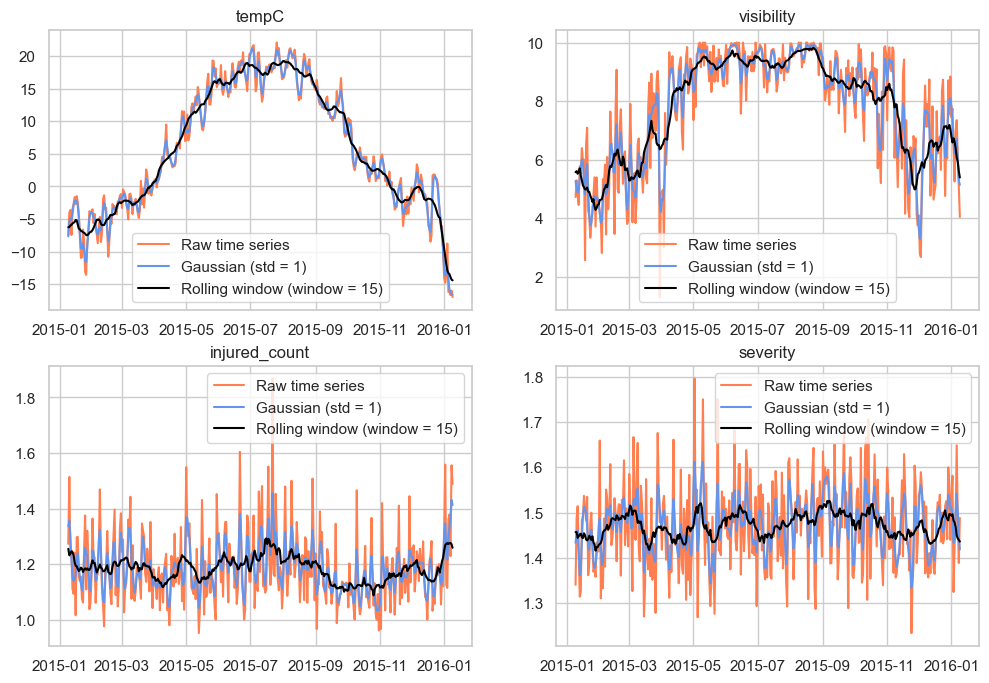

In [13]:
for num, item in enumerate(ts.columns):
    ts1 = ts[8:365+9]
    ts2 = ts_roll[8:365+9]
    ts3 = ts_gauss[8:365+9]
    plt.subplot(2, 2, num+1)
    plt.title(item)
    plt.plot(ts1[item], label="Raw time series", \
             color="coral")
    plt.plot(ts3[item], label=f"Gaussian (std = {std})", \
             color="cornflowerblue")
    plt.plot(ts2[item], label=f"Rolling window (window = {window_size})", \
             color="black")
    plt.legend()

# Step 5: Spectral density function with and without filters

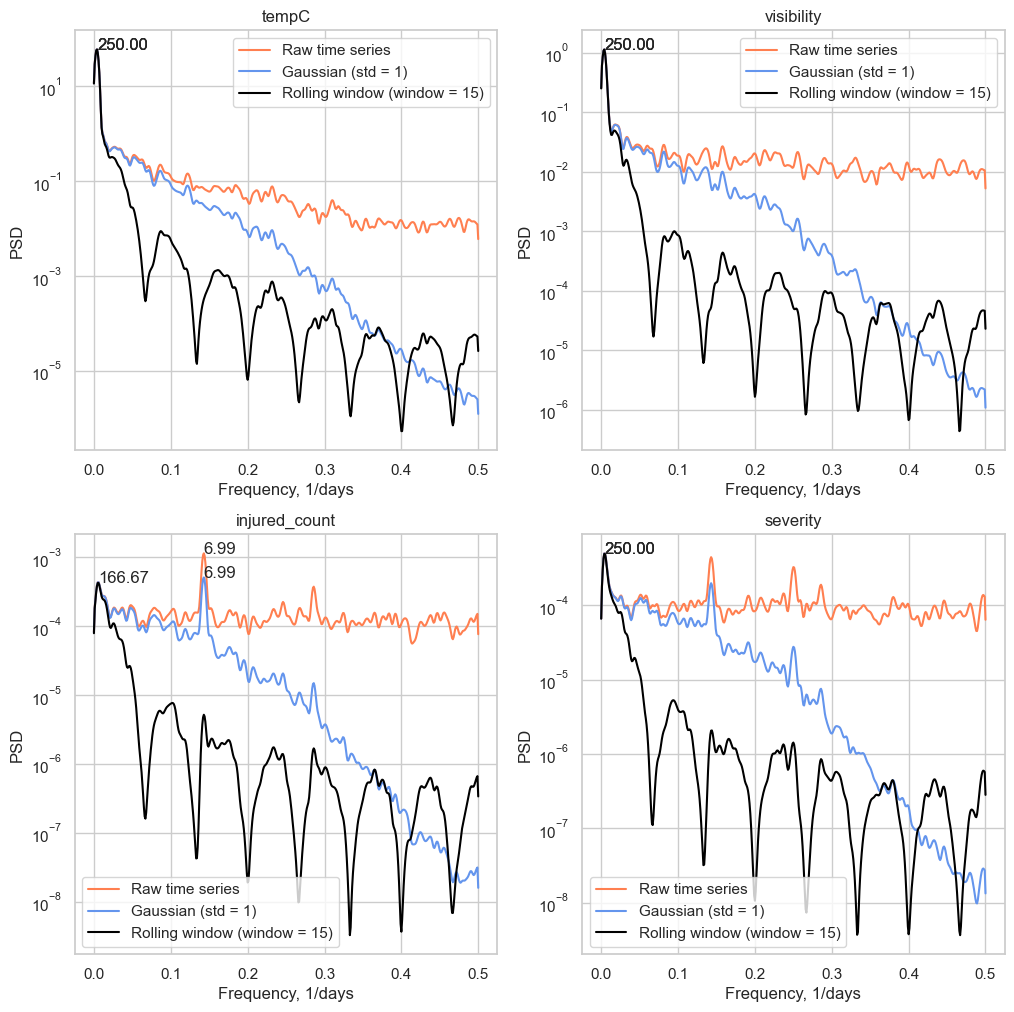

In [14]:
blackman = signal.blackman(M=window_size)

plt.rcParams["figure.figsize"] = (12, 12)

for num, item in enumerate(ts.columns):
    ts1 = ts[8:-8]
    ts2 = ts_roll[8:-8]
    ts3 = ts_gauss[8:-8]
    f_raw, Pxx_raw = signal.welch(ts1[item], fs=1, scaling='spectrum', nfft=1000)
    f_roll, Pxx_roll = signal.welch(ts2[item], fs=1, scaling='spectrum', nfft=1000)
    f_gauss, Pxx_gauss = signal.welch(ts3[item], fs=1, scaling='spectrum', nfft=1000)
    
    max_raw = np.where(Pxx_raw == max(Pxx_raw))
    max_roll = np.where(Pxx_roll == max(Pxx_roll))
    max_gauss = np.where(Pxx_gauss == max(Pxx_gauss))
    
    xy_raw = (f_raw[max_raw], Pxx_raw[max_raw])
    xy_roll = (f_roll[max_roll], Pxx_roll[max_roll])
    xy_gauss = (f_gauss[max_gauss], Pxx_gauss[max_gauss])
    
    plt.subplot(2, 2, num+1)
    plt.title(item)
    
    plt.semilogy(f_raw, Pxx_raw, \
             label="Raw time series", \
             color="coral")
    plt.annotate(f'{1/float(xy_raw[0]):.2f}', xy=xy_raw)
    
    plt.semilogy(f_gauss, Pxx_gauss, \
             label=f"Gaussian (std = {std})", \
             color="cornflowerblue")
    plt.annotate(f'{1/float(xy_gauss[0]):.2f}', xy=xy_gauss)
    
    plt.semilogy(f_roll, Pxx_roll, \
             label=f"Rolling window (window = {window_size})", \
             color="black")
    plt.annotate(f'{1/float(xy_roll[0]):.2f}', xy=xy_roll)
    
    plt.xlabel("Frequency, 1/days")
    plt.ylabel("PSD")
    plt.legend()
    
plt.rcParams["figure.figsize"] = (12, 8)

Maxima of spectral density functions are annotated in black text (those values are periods that correspond to frequencies).

# Step 6: Auto-regression models

## tempC

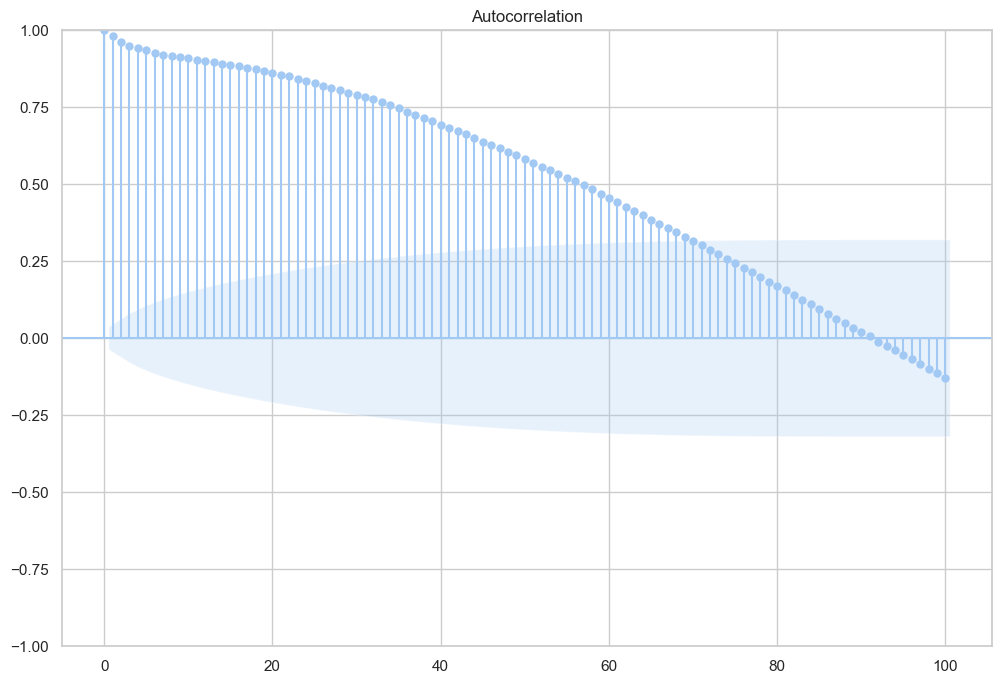

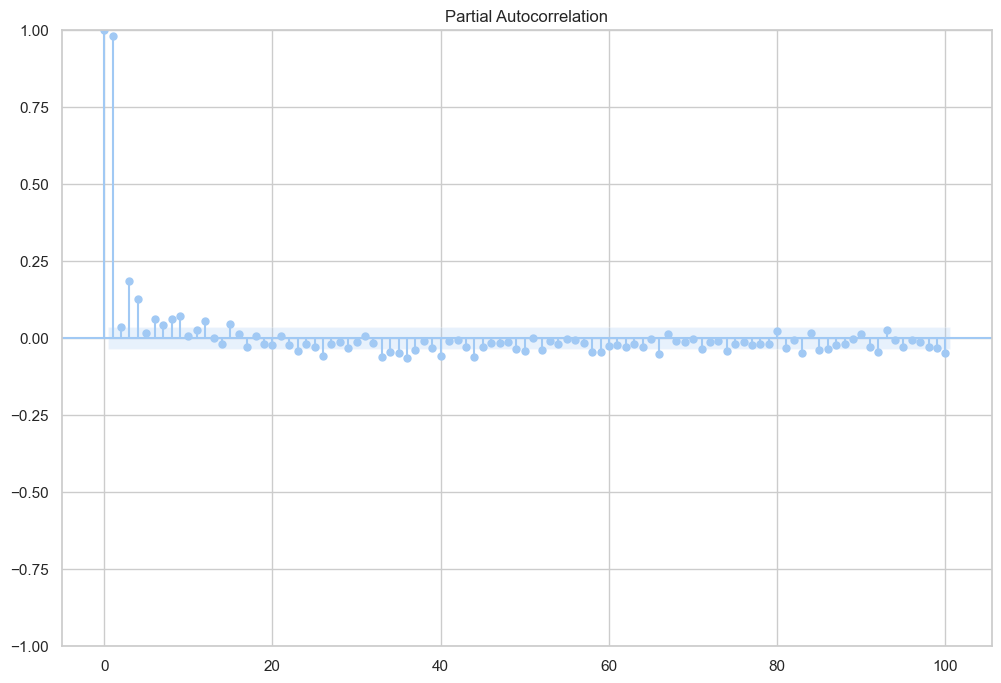

In [15]:
var = 'tempC'
acf_raw = plot_acf(ts[var], lags=100)
pacf_raw = plot_pacf(ts[var], lags=100)

SARIMA model:
- d = 0, as the dataset is stationary without differencing;
- the rest are optimized automatically.

In [16]:
#ar_order = 5
pred_list = []

ts1 = ts[8:-8]
ts2 = ts_roll[8:-8]
ts3 = ts_gauss[8:-8]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0], d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2276
Model:               SARIMAX(6, 0, 2)   Log Likelihood               -4812.233
Date:                Tue, 06 Dec 2022   AIC                           9642.467
Time:                        20:42:24   BIC                           9694.039
Sample:                    01-09-2015   HQIC                          9661.279
                         - 04-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7963      0.024    117.040      0.000       2.750       2.843
ar.L2         -2.7564      0.062    -44.235      0.000      -2.878      -2.634
ar.L3          1.1671      0.080 

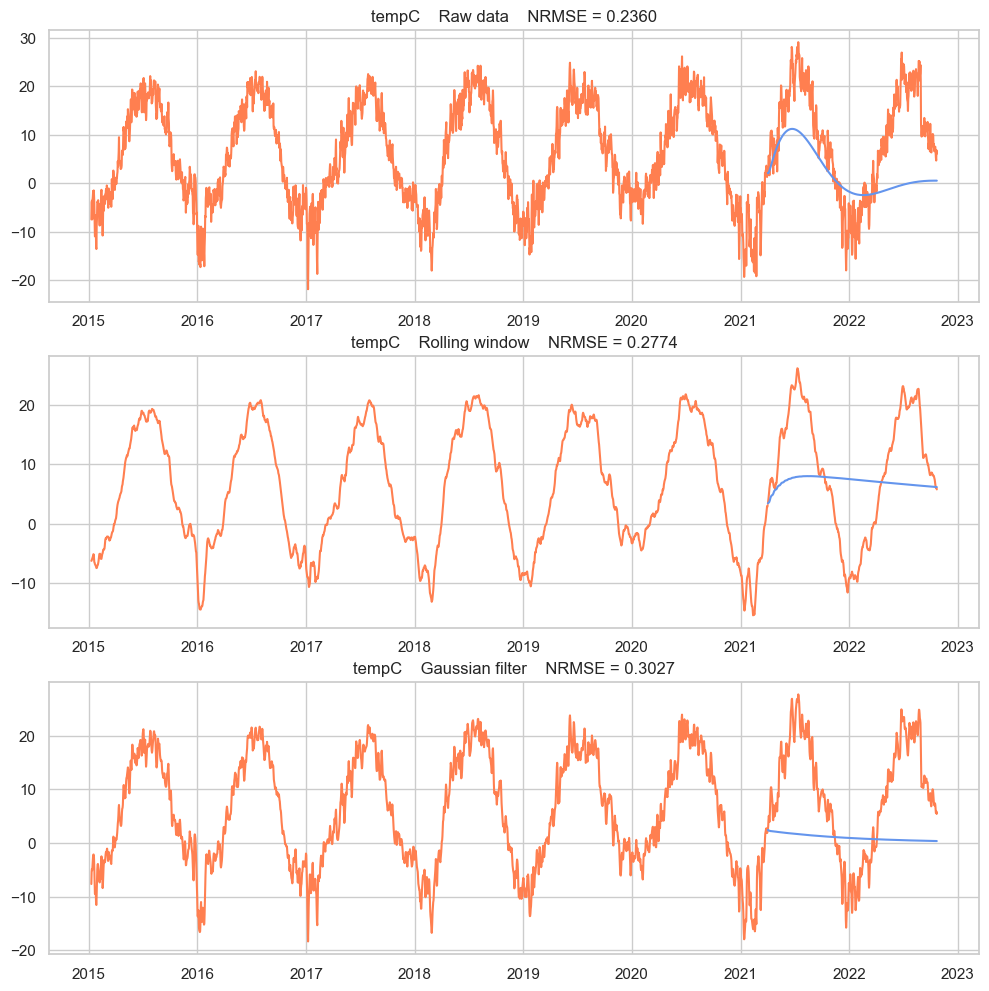

In [17]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## visibility

In [18]:
var = 'visibility'
pred_list = []

ts1 = ts[8:-8]
ts2 = ts_roll[8:-8]
ts3 = ts_gauss[8:-8]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0], d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2276
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -3604.395
Date:                Tue, 06 Dec 2022   AIC                           7218.790
Time:                        21:30:58   BIC                           7247.441
Sample:                    01-09-2015   HQIC                          7229.241
                         - 04-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0710      0.025      2.863      0.004       0.022       0.120
ar.L1          0.9910      0.003    288.739      0.000       0.984       0.998
ma.L1         -0.6660      0.017 

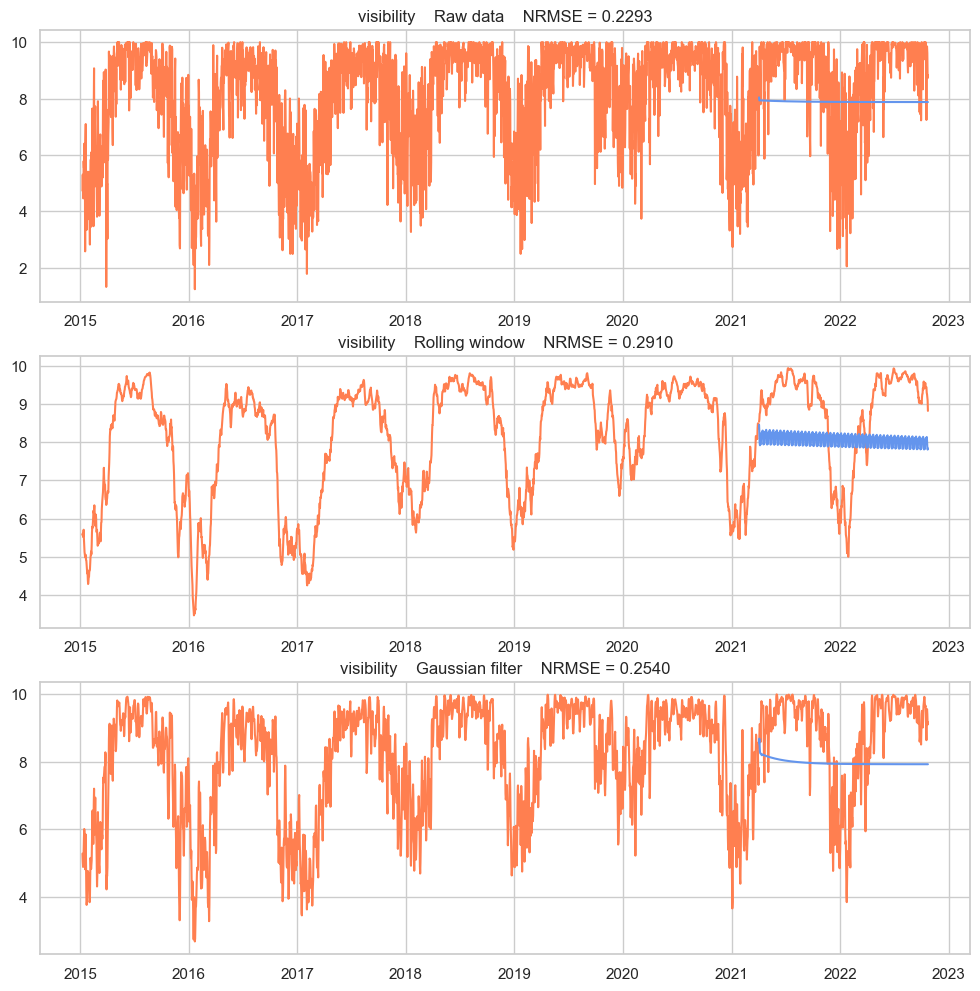

In [19]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## injured_count

In [20]:
var = 'injured_count'
pred_list = []

ts1 = ts[8:-8]
ts2 = ts_roll[8:-8]
ts3 = ts_gauss[8:-8]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0], d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2276
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1736.383
Date:                Tue, 06 Dec 2022   AIC                          -3466.767
Time:                        21:48:45   BIC                          -3449.576
Sample:                    01-09-2015   HQIC                         -3460.496
                         - 04-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1777      0.003    374.554      0.000       1.171       1.184
ma.L1          0.1656      0.020      8.478      0.000       0.127       0.204
sigma2         0.0127      0.000 

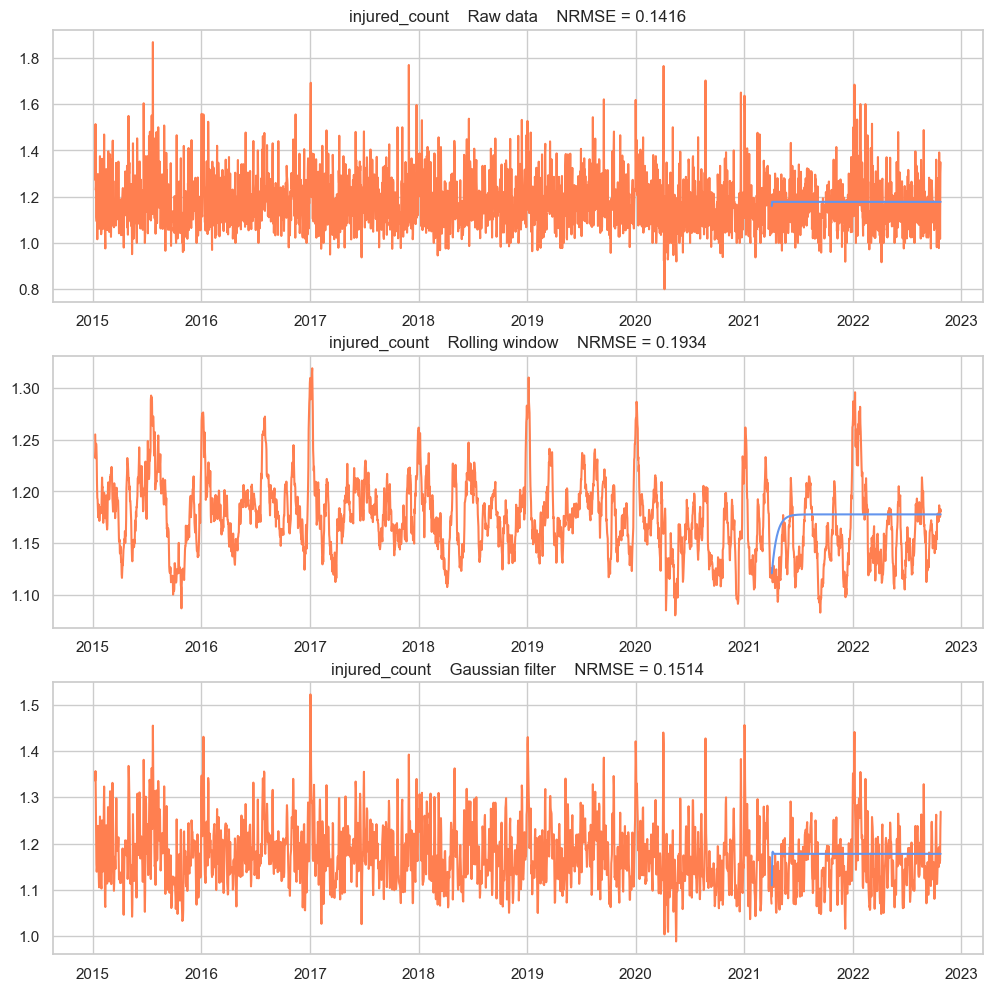

In [21]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

## severity

In [22]:
var = 'severity'
pred_list = []

ts1 = ts[8:-8]
ts2 = ts_roll[8:-8]
ts3 = ts_gauss[8:-8]
data_names = ['Raw data', 'Rolling window', 'Gaussian filter']

ar_data = np.array([[*train_test_split(ts1[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts2[var], test_size=0.2, shuffle=False)],
          [*train_test_split(ts3[var], test_size=0.2, shuffle=False)]])

# first index:     raw, roll, gauss
# second index:    train, test

plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    cur_time = time.time()
    
    D = pm.arima.nsdiffs(ar_data[num, 0], m=12, max_D=5)
    print(f"D = {D}")
    
    stepwise_model = pm.auto_arima(ar_data[num, 0], d=0,
                            start_p=1, max_p=12,
                            start_q=1, max_q=12,
                            D=D,
                            m=12,
                            seasonal=True,
                            stationary=True,
                            information_criterion='aic',
                            stepwise=True,
                            suppress_warnings=True)
    print("\n\n\n", data_names[num])
    
    stepwise_model.fit(ar_data[num, 0])
    print(stepwise_model.summary(), "\n\n\n")
    
    pred = stepwise_model.predict(len(ar_data[num, 1]))
    pred_list.append(pred)
    
    delta_time = time.time() - cur_time
    print(f"Model {num+1} out of 3 done in {delta_time} seconds.")

D = 0



 Raw data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2276
Model:               SARIMAX(4, 0, 4)   Log Likelihood                2153.888
Date:                Tue, 06 Dec 2022   AIC                          -4287.776
Time:                        22:03:50   BIC                          -4230.474
Sample:                    01-09-2015   HQIC                         -4266.873
                         - 04-02-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0482      0.033      1.445      0.148      -0.017       0.114
ar.L1          0.0761      1.037      0.073      0.942      -1.956       2.108
ar.L2       3.198e-07      0.695 

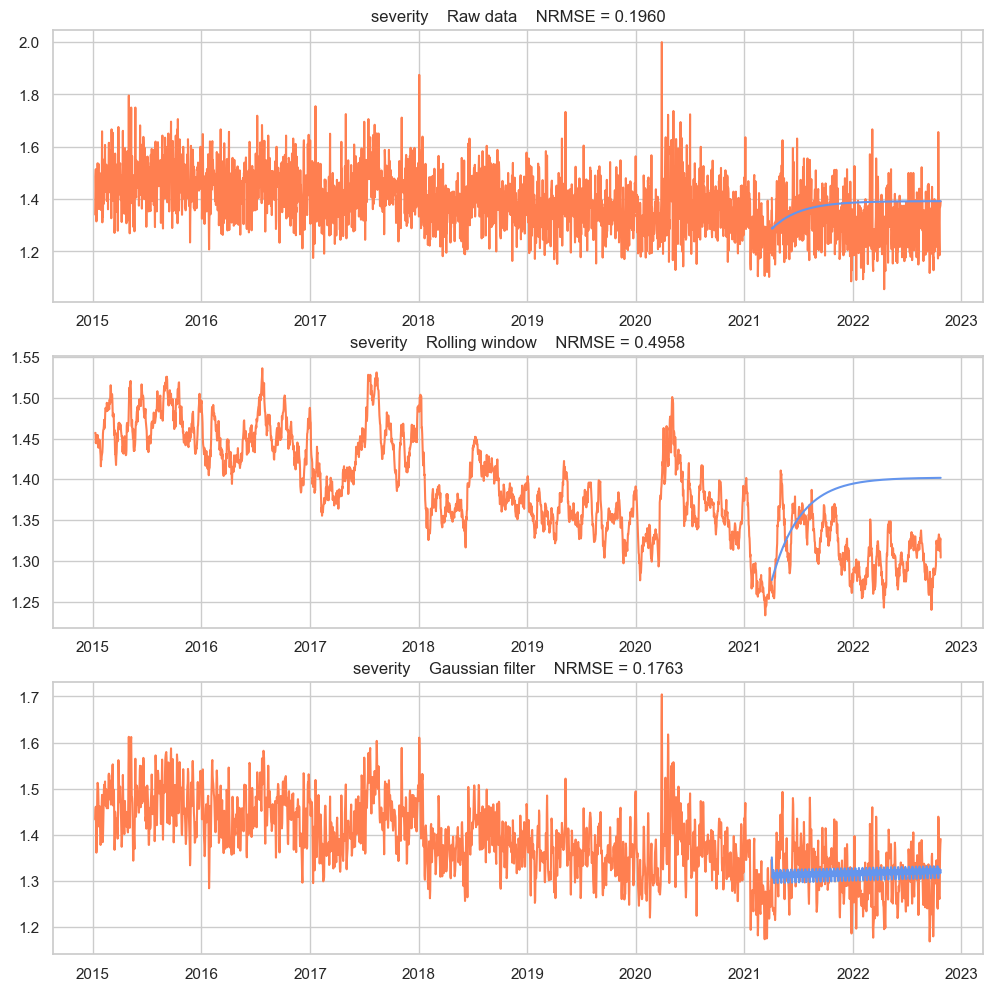

In [23]:
plt.rcParams["figure.figsize"] = (12, 12)
for num in range(3):
    plt.subplot(3, 1, num+1)
    pred_list[num].head()
    nrmse = rmse(pred_list[num], \
                 ar_data[num, 1]) / (np.max(ar_data[num, 1])-np.min(ar_data[num, 1]))
    
    plt.title(f"{var}    {data_names[num]}    NRMSE = {nrmse:.4f}")
    plt.plot(ar_data[num, 0], color='coral')
    plt.plot(ar_data[num, 1], color='coral')
    plt.plot(pred_list[num], color='cornflowerblue')
    
plt.rcParams["figure.figsize"] = (12, 8)

# Step 7: Linear dynamical system

In [24]:
nobs = 420
ts1_train = ts1[['tempC', 'visibility']][0:-nobs]
ts1_test = ts1[['tempC', 'visibility']][-nobs:]

print(ts1_train.shape)
print(ts1_test.shape)

(2425, 2)
(420, 2)


<AxesSubplot:xlabel='i'>

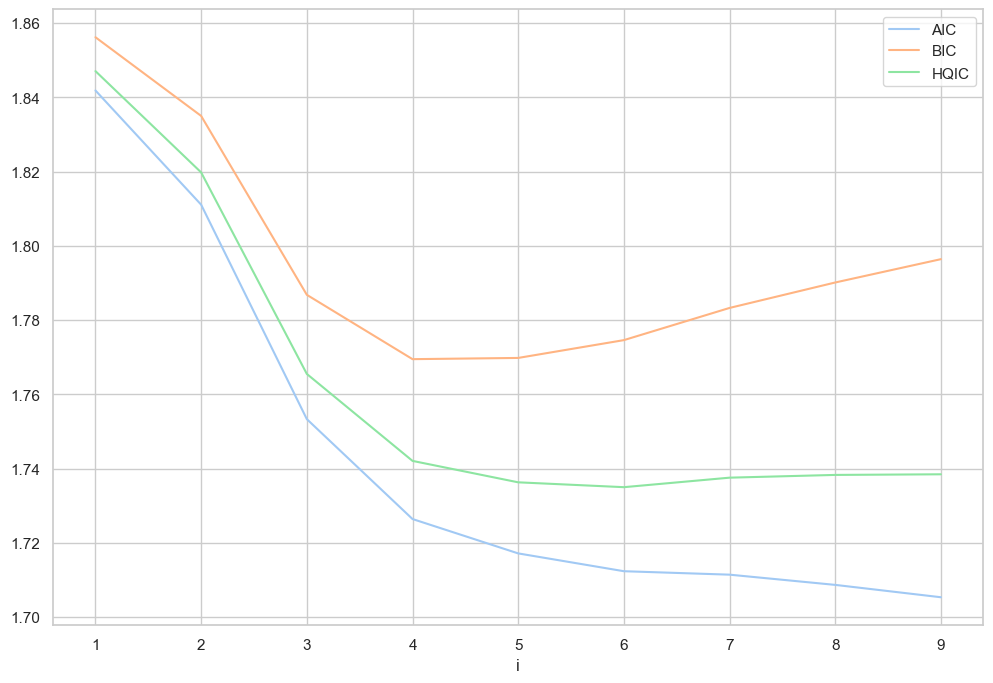

In [25]:
res_df = pd.DataFrame(columns=['i', 'AIC', 'BIC', 'FPE', 'HQIC'])

model = VAR(ts1_train)
for i in range(1, 10):
    result = model.fit(i)
    res_df = res_df.append({'i': i, 'AIC': result.aic, 'BIC': result.bic, \
                            'FPE': result.fpe, 'HQIC': result.hqic}, ignore_index=True)
    
res_df.set_index('i', inplace=True)

res_df.drop(columns=['FPE']).plot()

Model of order 4 selected

In [26]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 06, Dec, 2022
Time:                     22:14:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.76946
Nobs:                     2421.00    HQIC:                   1.74205
Log likelihood:          -8942.30    FPE:                    5.62036
AIC:                      1.72640    Det(Omega_mle):         5.57880
--------------------------------------------------------------------
Results for equation tempC
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -1.010426         0.307183           -3.289           0.001
L1.tempC              0.907152         0.020218           44.869           0.000
L1.visibility         0.125943         0.035470            3

In [27]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(ts1.columns, out):
    print(f'{col}: {round(val, 2)}')

tempC: 2.0
visibility: 2.03


In [28]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = ts1_train.values[-lag_order:]
forecast_input

4


array([[16.76363636,  9.30909091],
       [20.3442623 , 10.        ],
       [19.70175439,  9.85964912],
       [18.66666667,  9.68627451]])

In [29]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=ts1[['tempC', 'visibility']].index[-nobs:], \
                           columns=ts1[['tempC', 'visibility']].columns)
df_forecast

,tempC,visibility
datetime,,
2021-08-30,18.264847,9.706471
2021-08-31,18.407265,9.778374
2021-09-01,18.462848,9.740179
2021-09-02,18.345761,9.695440
2021-09-03,18.181593,9.686187
...,...,...
2022-10-19,7.673632,8.280895
2022-10-20,7.671539,8.280614
2022-10-21,7.669465,8.280335


In [30]:
rrmse_df = ((((ts1_test-df_forecast)**2).mean(axis=0)) / ((ts1_test**2).sum(axis=0)))**0.5*100
rrmse_df

tempC         4.752019
visibility    0.992936
dtype: float64

In [31]:
df_forecast.tail()

,tempC,visibility
datetime,,
2022-10-19,7.673632,8.280895
2022-10-20,7.671539,8.280614
2022-10-21,7.669465,8.280335
2022-10-22,7.667411,8.280059
2022-10-23,7.665376,8.279785


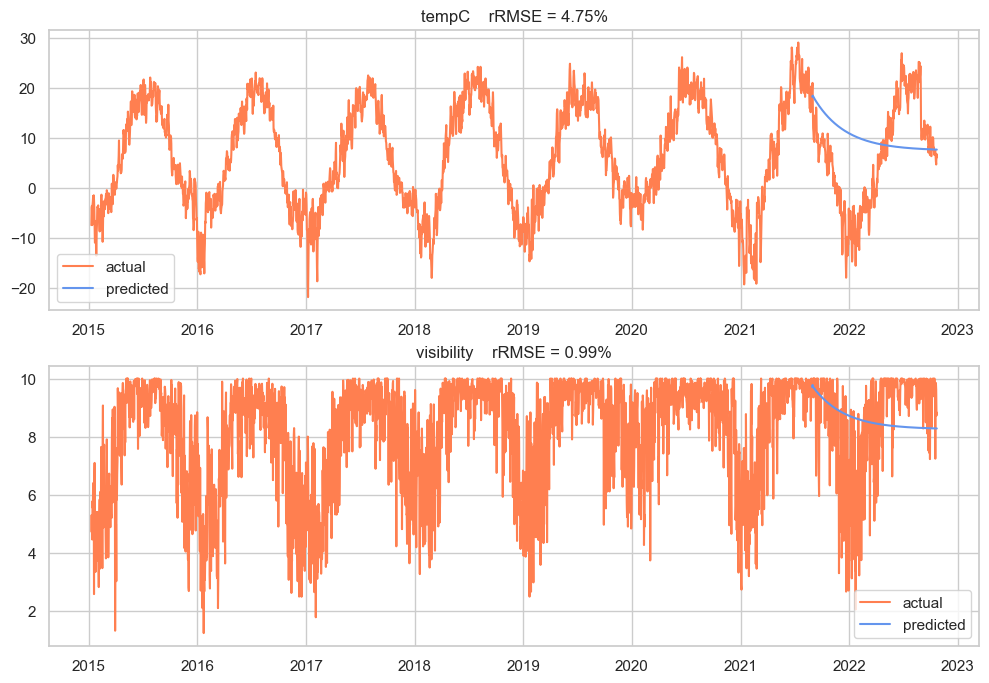

In [32]:
rrmse_tempC = rrmse_df['tempC']

plt.subplot(2, 1, 1)
plt.plot(ts1[['tempC']], label="actual", color='coral')
plt.plot(df_forecast[['tempC']], label="predicted", color='cornflowerblue')
plt.title(f"tempC    rRMSE = {rrmse_tempC:.2f}%")
plt.legend()

rrmse_visibility = rrmse_df['visibility']

plt.subplot(2, 1, 2)
plt.plot(ts1[['visibility']], label="actual", color='coral')
plt.plot(df_forecast[['visibility']], label="predicted", color='cornflowerblue')
plt.title(f"visibility    rRMSE = {rrmse_visibility:.2f}%")
plt.legend()

In [33]:
import dill
dill.dump_session('./lab4_session.db')